In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Read data

In [2]:
df_mic = pd.read_excel("City to microregion.xlsx")
df_hist = pd.read_excel("Historical deforestation rate.xlsx")
df_val = pd.read_excel("Value of agribusiness production.xlsx")

# Important to use utf-8, as 'açaí' will need a better encoding than default ascii
with open('../historical-database.csv', 'r', encoding='utf-8') as f:
    data = f.read()

data = data.split('\n')
# Separating columns manually
columns = data[0]
data = data[1:-1]
# Remove ending comma, then split by semi-colon
columns = columns[:-1].split(';')

# Transform dates
def date_handler(date: pd.Timestamp):
    return date.year - 1985

# Retransform dates back to pd.Timestamp
def date_reverse(date: int) -> pd.Timestamp:
    return pd.Timestamp(date + 1985, 1, 1)

# Simple example to check that date encoding is working
# sample_date = pd.Timestamp(2015, 1, 1)
# cvt_date = date_handler(sample_date)
# print(f'{sample_date=}\n{cvt_date=}\n{date_reverse(cvt_date)=}')

def process_line(line: str) -> list:
    entries = line.split(';')
    if ',' in entries[-1] and len(entries[-1])>1:
        entries[-1] = float(entries[-1].replace(',','.',-1))
    elif len(entries[-1]) <= 1:
        entries[-1] = None
    else:
        entries[-1] = float(entries[-1])
    # Convert to python-friendly date format.
    entries[0] = datetime.datetime.strptime(entries[0],"%d/%m/%Y")
    return entries

data = list(map(process_line, data))
df_orig = pd.DataFrame(data=data, columns=columns)
# df_orig['year'] = df_orig['year'].apply(date_handler)
# df_orig = df_orig.drop(df_orig[df_orig['year']<0].index, axis = 0)
type_dict = [(val, tip) for tip, val in df_orig[['product_type', 'product']].value_counts().index.to_list() if val != "Others"]
type_dict.append(('Permanent-other', 'permanent'))
type_dict.append(('Temporary-other', 'temporary'))
type_dict = {prod: tip for prod, tip in type_dict}
df_orig.loc[(df_orig['product_type'] == "permanent") & (df_orig['product'] == 'Others'), 'product'] = 'Permanent-other'
df_orig.loc[(df_orig['product_type'] == "temporary") & (df_orig['product'] == 'Others'), 'product'] = 'Temporary-other'
df_orig = df_orig.drop('product_type', axis=1)
df = df_orig.copy(deep=True)
df_orig;

d:\Python\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
d:\Python\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
d:\Python\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


# Merges

In [3]:
df_hist["Deforest_Mean"] = df_hist[['Deforestation area 2017 (Km2)', 'Deforestation area 2018 (Km2)', 'Deforestation area 2019 (Km2)']].sum(axis=1)*(1/3)
df_hist["Deforest_Rate"] = df_hist["Deforest_Mean"]/df_hist['Total city area (Km2)']
df_hist = df_hist.drop(['Deforestation area 2017 (Km2)', 'Deforestation area 2018 (Km2)', 'Deforestation area 2019 (Km2)'], axis=1)

df_mic_hist = df_mic.merge(df_hist, on=['City ID_CodIbge', 'City'], how='right')

df_avg_by_mic = df_mic_hist[['Microregion','Total city area (Km2)', 'Deforest_Rate']].groupby('Microregion').sum().reset_index().drop('Total city area (Km2)', axis=1)

df_mic_prod_area_by_year = df_mic.merge(df_orig, on='city_code', how='right')[['year', 'Microregion', 'product', 'destinated_area']].groupby(['year', 'Microregion', 'product']).sum().reset_index()

df_mic_prod_area_by_year = df_mic_prod_area_by_year.loc[df_mic_prod_area_by_year['year'] == '2017-01-01'].reset_index().drop('index',axis=1)
df_mic_prod_area_by_year = df_mic_prod_area_by_year.rename({'product':'Product'}, axis=1)

df_mic_prod_value_by_year = df_mic.merge(df_val, on='City ID_CodIbge', how='right')[['Microregion', 'Product', 'Production value (R$ thousands)']].groupby(['Microregion', 'Product']).sum().reset_index()

val_by_area = df_mic_prod_value_by_year.merge(df_mic_prod_area_by_year, on=['Microregion', 'Product'], how = 'outer')

val_by_area = val_by_area.dropna(axis=0).drop('year',axis=1)
val_by_area.loc[val_by_area['destinated_area'] == 0, 'Production value (R$ thousands)'] = 0
val_by_area.loc[val_by_area['destinated_area'] == 0, 'destinated_area'] = 1
val_by_area['Productivity'] = val_by_area['Production value (R$ thousands)']/val_by_area['destinated_area']
val_by_area = val_by_area.drop(['Production value (R$ thousands)'], axis=1)


In [4]:
df_avg_productivity = df_avg_by_mic.merge(val_by_area, on = 'Microregion', how='left')

def apply_labels(x):
    if x in ['Livestock', 'Soy']: 
        return 5    
    elif x in ['Sorghum', 'Corn']: 
        return 4 
    elif x in ['Beans', 'Cassava', 'Rice']: 
        return 3
    elif x in ['Palm oil', 'Açaí', 'Cocoa']:
        return 1
    else: 
        return 2

# :(
df_avg_productivity['Ranking'] = df_avg_productivity['Product'].apply(apply_labels)
df_avg_productivity.head(3)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking
0,Almeirim,0.002108,Açaí,378.0,20.261905,1
1,Almeirim,0.002108,Beans,105.0,1.323810,3
2,Almeirim,0.002108,Cassava,580.0,5.727586,3


# Normalizing columns and calculate score

Priorization Matrix

In [5]:
df_avg_productivity['Deforest_Rate'] = (df_avg_productivity['Deforest_Rate']-df_avg_productivity['Deforest_Rate'].min())/df_avg_productivity['Deforest_Rate'].max()*10
df_avg_productivity['destinated_area'] = (df_avg_productivity['destinated_area']-df_avg_productivity['destinated_area'].min())/df_avg_productivity['destinated_area'].max()*10
df_avg_productivity['Productivity'] = (df_avg_productivity['Productivity']-df_avg_productivity['Productivity'].min())/df_avg_productivity['Productivity'].max()*10
df_avg_productivity['Ranking'] = (df_avg_productivity['Ranking']-df_avg_productivity['Ranking'].min())/df_avg_productivity['Ranking'].max()*10
df_avg_productivity.describe()

,Deforest_Rate,destinated_area,Productivity,Ranking
count,220.000000,220.000000,220.000000,220.000000
mean,1.819090,0.345938,0.233018,4.000000
std,2.141168,1.306543,0.724511,2.973244
min,0.000000,0.000000,0.000000,0.000000
25%,0.527050,0.000000,0.000000,0.000000
50%,1.004050,0.002162,0.071554,4.000000
75%,2.490429,0.035480,0.228074,6.000000
max,9.947457,9.999997,10.000000,8.000000


In [6]:
weights = {
'Deforest_Rate' : 0.25,
'destinated_area': 0.4,
'Productivity': 0.1,
'Ranking': 0.25
}

s = np.zeros(shape=(df_avg_productivity.shape[0],))
for k, v in weights.items():
    s += df_avg_productivity[k]*v

df_avg_productivity['Score'] = s
df_avg_productivity.sort_values('Score', ascending=False).head(3)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking,Score
15,Altamira,9.947457,Livestock,8.103128,0.152626,8.0,7.743378
185,São Félix do Xingu,1.384758,Livestock,9.999997,0.182390,8.0,6.364427
205,Tucuruí,3.581024,Livestock,5.384318,0.178393,8.0,5.066823


In [7]:
df_no_altamira = df_avg_productivity.loc[(df_avg_productivity['Microregion'] != 'Altamira')&(df_avg_productivity['Product'] != 'Livestock')].sort_values('Score', ascending=False)
df_no_altamira.head(3)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking,Score
179,Santarém,3.890462,Soy,0.189715,0.149734,8.0,3.063475
129,Paragominas,2.490429,Soy,1.028709,0.191287,8.0,3.053220
109,Itaituba,3.604594,Soy,0.059048,0.130074,8.0,2.937775


In [8]:
df_no_santa = df_no_altamira.loc[(df_no_altamira['Microregion'] != 'Santarém')&(df_no_altamira['Product'] != 'Soy')].sort_values('Score', ascending=False)
df_no_santa.head(3)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking,Score
104,Itaituba,3.604594,Corn,0.042275,0.077964,6.0,2.425855
204,Tucuruí,3.581024,Corn,0.040440,0.025555,6.0,2.413988
108,Itaituba,3.604594,Sorghum,0.000000,0.000000,6.0,2.401148


In [9]:
df_no_itaituba = df_no_santa.loc[(df_no_santa['Microregion'] != 'Itaituba')&(df_no_santa['Product'] != 'Corn')].sort_values('Score', ascending=False)
df_no_itaituba.head(3)

,Microregion,Deforest_Rate,Product,destinated_area,Productivity,Ranking,Score
208,Tucuruí,3.581024,Sorghum,0.00000,0.000000,6.0,2.395256
98,Guamá,3.053305,Sorghum,0.00000,0.000000,6.0,2.263326
128,Paragominas,2.490429,Sorghum,0.01699,0.054594,6.0,2.134863


C:\Users\cadud\AppData\Local\Temp\ipykernel_15180\3948538080.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


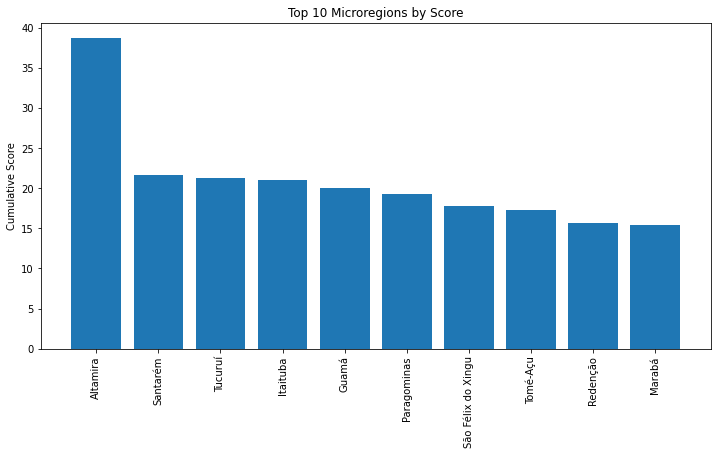

In [10]:
score_reg = np.array(df_avg_productivity[['Microregion', 'Score']].groupby('Microregion').sum().sort_values('Score', ascending=False).head(10).reset_index())
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.bar(range(len(score_reg)), score_reg[:,1])
ax.set_xticks(range(len(score_reg)), score_reg[:,0], rotation=90)
ax.set_ylabel('Cumulative Score')
ax.set_title('Top 10 Microregions by Score')
fig.show();

C:\Users\cadud\AppData\Local\Temp\ipykernel_15180\2888267094.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


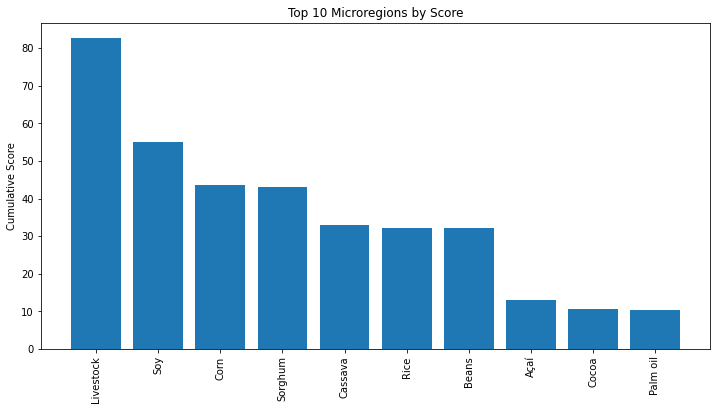

In [13]:
score_prod = np.array(df_avg_productivity[['Product', 'Score']].groupby('Product').sum().sort_values('Score', ascending=False).head(10).reset_index())
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.bar(range(len(score_prod)), score_prod[:,1])
ax.set_xticks(range(len(score_prod)), score_prod[:,0], rotation=90)
ax.set_ylabel('Cumulative Score')
ax.set_title('Top 10 Microregions by Score')
fig.show();

Altamira => Livestock

Santarém => Soy

Itaituba => Corn

Tucuruí => Sorghum